# Darcy equation

In this tutorial we present how to solve a Darcy equation with [PyGeoN](https://github.com/compgeo-mox/pygeon).  The unkwons are the velocity $q$ and the pressure $p$.

Let $\Omega=(0,2)\times(0,3)$ with boundary $\partial \Omega$ and outward unit normal ${\nu}$. Given 
$k$ the matrix permeability, we want to solve the following problem: find $({q}, \psi)$ such that
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
K^{-1}(\psi) {q} + \nabla \psi = -\nabla z\\
\partial_t \theta (\psi) + \nabla \cdot {q} = 0
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$
with boundary conditions:

$$
\psi(t,x,z)=
\left\{
\begin{array}{ll}
\begin{array}{l} 
-2+2.2 \frac{t}{\Delta t_D}, \text{ on } \Gamma_{D_1}, t\leq\Delta t_D\\
0.2, \text{ on } \Gamma_{D_1}, t>\Delta t_D\\
1-z, \text{ on } \Gamma_{D_2}
\end{array}
\end{array}
\right., \qquad \nu \cdot q = 0 \text{ on } \Gamma_N \qquad \psi(0,x,z) = 1-z \text{ on } \Omega$$
and
$$
\Gamma_{D_1} = \left\{ (x,z) \in \partial \Omega \:|\: x \in [0,1] \wedge z=3  \right\},\\
\Gamma_{D_2} = \left\{ (x,z) \in \partial \Omega \:|\: x = 2 \wedge z \in [0,1]  \right\},\\
\Gamma_{D} = \Gamma_{D_1} \cup \Gamma_{D_2},\\
\Gamma_{N} = \partial \Omega \setminus \Gamma_D
$$

We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem.

### Import and parameters

In [1]:
import shutil
import os

import numpy as np
import scipy.sparse as sps
import sympy as sp

import porepy as pp
import pygeon as pg

from math import ceil, floor

import matplotlib.pyplot as plt

In [2]:
K = 30
N = 25

eps = 1e-3
domain_tolerance = 1 / (10 * N)

output_directory = 'output_evolutionary'

In [3]:
rho = 1000
g = pp.GRAVITY_ACCELERATION

In [4]:
theta_s = 0.396
theta_r = 0.131

alpha = 0.423

n = 2.06
K_s = 4.96e-2

In [ ]:
dt_D = 1/16
dt   = 1/48
T    = 3/16

### $\theta$ and $k$, with their derivatives w.r.t. $\psi$

In [5]:
def theta(psi):
    res = np.ones_like(psi) * theta_s

    mask = psi <= 0
    res[mask] = theta_r + (theta_s  - theta_r) * 1 / np.power(1 + np.power(-alpha * psi[mask], n), (n-1)/n)

    return res

In [6]:
def dtheta_dpsi(psi, order=1):
    if order == 0:
        return theta(psi)


    psi_var = sp.Symbol('psi', negative=True)
    diff = sp.diff( theta_r + (theta_s  - theta_r) * (1 / (1+(-alpha * psi_var) ** n)) ** ((n-1)/n) , psi_var, order )
    
    res = np.zeros_like(psi)

    mask = psi <= 0
    res[mask] = np.array( list( diff.subs(psi_var, val).evalf() for val in psi[mask] ) )

    return res

In [7]:
def conductivity_coeff(psi):
    coeff = np.ones_like(psi) * K_s

    mask = psi <= 0
    th = theta(psi[mask])
    coeff[mask] = K_s * np.power(th, (1/2)) * np.power( 1 - np.power( 1 - np.power(th , ( n / (n-1) ) ), ((n-1)/n)), 2)

    return coeff

In [8]:
def dconductivity_coeff_dpsi(psi, order=1):
    if order == 0:
        return conductivity_coeff(psi)
    
    coeff = np.zeros_like(psi)

    mask = psi <= 0

    psi_var = sp.Symbol('psi', negative=True)
    exp = theta_r + (theta_s  - theta_r) * (1 / (1+(-alpha * psi_var) ** n)) ** ((n-1)/n)

    diff = sp.diff( K_s * (exp ** (1/2)) * ( 1 - ( 1 - ( exp ** ( n / (n-1) ) ) ) ** ((n-1)/n) ) ** 2, psi_var, order)

    coeff[mask] = np.array(list(diff.subs(psi_var, val).evalf() for val in psi[mask]))

    return coeff

In [9]:
def dconductivity_tensor_dpsi(psi, order=1):
    return pp.SecondOrderTensor(dconductivity_coeff_dpsi(psi, order))

In [10]:
def conductivity_tensor(psi):
    return dconductivity_tensor_dpsi(psi, 0)

In [11]:
def quick_plot(theta_der = 0, cond_der = 0):
    psi_val = np.linspace(-10, 5, 100)
    theta_val = dtheta_dpsi(psi_val, theta_der)
    kappa_val = dconductivity_coeff_dpsi(psi_val, cond_der)

    theta_max = theta_s
    theta_min = theta_r

    kappa_max = K_s
    kappa_min = dconductivity_coeff_dpsi(np.array([-1e10]), cond_der)

    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.plot(psi_val, theta_val)
    ax1.plot(psi_val, theta_max * np.ones_like(psi_val), linestyle="--", color="red")
    ax1.plot(
        psi_val,
        theta_min * np.ones_like(psi_val),
        linestyle="--",
        color="green",
    )
    ax1.set_title("theta")

    ax2.plot(psi_val, kappa_val)
    ax2.plot(psi_val, kappa_max * np.ones_like(psi_val), linestyle="--", color="red")
    ax2.plot(
        psi_val,
        kappa_min * np.ones_like(psi_val),
        linestyle="--",
        color="green",
    )
    ax2.set_title("kappa")

    plt.show()

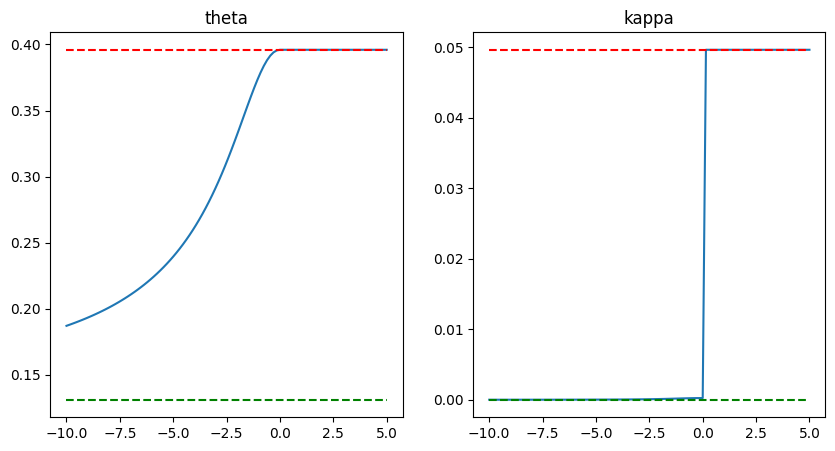

In [12]:
quick_plot(0, 0)

### Domain preparation

In [13]:
subdomain = pp.StructuredTriangleGrid([2*N, 3*N], [2,3])
# convert the grid into a mixed-dimensional grid
mdg = pp.meshing.subdomains_to_mdg([subdomain])

In [14]:
key = "flow"

bc_value = []
bc_essential = []
initial_pressure = []

gravity = []

RT0 = pg.RT0(key)
P0  = pg.PwConstants(key)

In [15]:
def g_func(x): 
    return np.array([0, -1, -1])

In [16]:
def initial_pressure_func(x): 
    return 1-x[1]

In [17]:
for subdomain, data in mdg.subdomains(return_data=True):
    g_proj = RT0.interpolate(subdomain, g_func)
    gravity.append(RT0.assemble_mass_matrix(subdomain) @ g_proj)
    initial_pressure.append(P0.interpolate(subdomain, initial_pressure_func))
        
    # with the following steps we identify the portions of the boundary
    # to impose the boundary conditions
    boundary_faces_indexes = subdomain.get_boundary_faces()

    gamma_d1 = np.logical_and(subdomain.face_centers[0, :] > 0-domain_tolerance, np.logical_and(subdomain.face_centers[0, :] < 1+domain_tolerance, subdomain.face_centers[1, :] > 3-domain_tolerance))
    gamma_d2 = np.logical_and(subdomain.face_centers[0, :] > 2-domain_tolerance, np.logical_and(subdomain.face_centers[1, :] > 0-domain_tolerance, subdomain.face_centers[1, :] < 1+domain_tolerance))

    gamma_d  = np.logical_or(gamma_d1, gamma_d2)
    
    gamma_n  = gamma_d.copy()
    gamma_n[boundary_faces_indexes] = np.logical_not(gamma_n[boundary_faces_indexes])
    
    def bc_gamma_d(x, t):
        if   x[0] > 2-domain_tolerance and x[1] > 0-domain_tolerance and x[1] < 1+domain_tolerance:
            res =  1 - x[1]
        elif x[1] > 3-domain_tolerance and x[0] > 0-domain_tolerance and x[0] < 1+domain_tolerance:
            res = min( 0.2, -2 + 2.2 * t / dt_D )
        else:
            res = 0
        
        return res

    bc_value.append(lambda t: - RT0.assemble_nat_bc(subdomain, lambda x: bc_gamma_d(x,t), gamma_d))

    essential_pressure_dofs = np.zeros(P0.ndof(subdomain), dtype=bool)
    bc_essential.append(np.hstack((gamma_n, essential_pressure_dofs)))

In [18]:
gamma_d.sum(), gamma_n.sum(), len(subdomain.get_boundary_faces())

(50, 200, 250)

A quick recap:
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
K^{-1}(\psi) {q} + \nabla \psi = -\nabla z\\
\partial_t \theta (\psi) + \nabla \cdot {q} = 0
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$
becames, with the time discretization:
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
K^{-1}(\psi) {q^{n+1}} + \nabla \psi^{n+1} = -\nabla z\\
\frac{\theta (\psi^{n+1}) - \theta (\psi^{n})}{\Delta t} + \nabla \cdot {q^{n+1}} = 0
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$

$$
Picard \qquad
\left\{
\begin{array}{ll}
\begin{array}{l} 
M^{n+1}_k q_{k+1}^{n+1} + B^T \psi^{n+1}_{k+1} = G^{n+1}\\
-B q_{k+1}^{n+1} + \psi_{k+1}^{n+1} = \psi_{k}^{n+1} + \frac{\Theta^n - \Theta^{n+1}_k}{\Delta t} + F^{n+1}
\end{array}
\end{array}
\right.
$$
where:
$$
[M^{n+1}_k]_{ij} = \left( K^{-1}(\psi^{n+1}_k) \Phi_j, \Phi_i \right)_{L^2(\Omega)}, \qquad [\Theta^n]_{i} = \left( \frac{\theta(\psi^n)}{\Delta t}, \Psi_i \right)_{L^2(\Omega)}, \qquad [\Theta^{n+1}_k]_{i} = \left( \frac{\theta(\psi^{n+1}_k)}{\Delta t}, \Psi_i \right)_{L^2(\Omega)}, \qquad [B]_{ij} = - \left( \Psi_i, \nabla \cdot \Phi_j \right)_{L^2(\Omega)}
$$


$$
Netwon \qquad
\left\{
\begin{array}{ll}
\begin{array}{l} 
M^{n+1}_k q_{k+1}^{n+1} + [B^T + C(\psi_k^{n+1}, q_ {k}^{n+1})] \psi^{n+1}_{k+1} = G^{n+1} + C(\psi_k^{n+1}, q_ {k}^{n+1}) \psi_k^{n+1} + BC^{n+1}\\
\frac{1}{\Delta t} D(\psi_{k}^{n+1}) \psi_{k+1}^{n+1} -B q_{k+1}^{n+1} = \frac{\Theta^n - \Theta^{n+1}_k}{\Delta t} + \frac{1}{\Delta t} D(\psi_{k}^{n+1}) \psi_{k}^{n+1} + F^{n+1}
\end{array}
\end{array}
\right.
$$
where:
$$
[C(\psi_k^{n+1}, q_ {k}^{n+1})]_{ij} = \int_{\Omega} \Psi_j \frac{\partial K^{-1}(\psi_k^{n+1})}{\partial \psi} \, q_k^{n+1} \cdot \Phi_i \, d\Omega = \alpha_j \int_{\omega_j} \frac{q_k^{n+1} \cdot \Phi_i}{k(\psi_k^{n+1})} \, d\Omega \qquad [D(\psi_{k}^{n+1})]_{ij} = \left( \frac{\partial \theta}{\partial \psi}(\psi_k^{n+1}) \Psi_j, \Psi_i \right)_{L^2(\Omega)}
$$

In [19]:
div = -pg.cell_mass(mdg) @ pg.div(mdg)

# get the degrees of freedom for each variable
dof_p, dof_q = div.shape
dof_psi = dof_p

In [20]:
proj_q   = RT0.eval_at_cell_centers(subdomain)
proj_psi =  P0.eval_at_cell_centers(subdomain)

def export_step(save, current_sol, step) -> None:
    q =  current_sol[:dof_q]
    psi = current_sol[-dof_psi:]

    for _, data in mdg.subdomains(return_data=True):
        data[pp.STATE] = {"cell_q": (proj_q @ q).reshape((3, -1), order="F"), 
                          "cell_p": (proj_psi @ psi)}
    
    save.write_vtu(["cell_q", "cell_p"], time_step=step)

In [21]:
def picard(sol_n, t_n_1, prev=None, iters=K, debug=False):
    if prev == None:
        prev = sol_n.copy()

    # assemble the right-hand side
    fixed_rhs = np.zeros(dof_psi + dof_q)

    # Natural BCs
    fixed_rhs[:dof_q] += np.hstack(list(cond(t_n_1) for cond in bc_value))

    # Gravity
    fixed_rhs[:dof_q] += np.hstack(gravity)

    # Theta^n
    fixed_rhs[-dof_psi:] += pg.cell_mass(mdg) @ theta(sol_n[-dof_psi:]) / dt

    if debug:
        save_debug = pp.Exporter(mdg, "sol_" + str(t_n_1), folder_name=output_directory + "/debug")
        export_step(save_debug, sol_n, 0)

    print('Time ' + str(round(t_n_1, 5)))

    for k in range(iters):

        rhs = fixed_rhs.copy()

        # Theta^{n+1}_k
        rhs[-dof_psi:] -= pg.cell_mass(mdg) @ theta(prev[-dof_psi:]) / dt

        rhs[-dof_psi:] += prev[-dof_psi:]
        #rhs += prev

        pp.initialize_data(subdomain, data, key, {
            "second_order_tensor": conductivity_tensor(prev[-dof_psi:]),
        })

        # construct the local matrices
        M_k_n_1 = None
        M_k_n_1 = pg.face_mass(mdg)


        # assemble the saddle point problem
        spp = sps.bmat([[M_k_n_1,                               div.T], 
                        [-div, np.diag(np.ones_like(prev[-dof_psi:]))]], format="csc")
        
        #spp = sps.bmat([[M_k_n_1+np.diag(np.ones_like(prev[:dof_q])),                               div.T], 
        #                [-div, np.diag(np.ones_like(prev[-dof_psi:]))]], format="csc")
        
        #spp = sps.bmat([[M_k_n_1,                               div.T], 
        #                [-div, None]], format="csc")
        
        # solve the problem
        ls = pg.LinearSystem(spp, rhs)
        ls.flag_ess_bc(np.hstack(bc_essential), np.zeros(dof_q + dof_psi))
    
        current = None
        current = ls.solve()

        if debug:
            export_step(save_debug, current, k+1)

        err = np.sqrt(np.sum(np.power(current-prev, 2)))

        

        print('Iteration #' + format(k+1, '0' + str(floor((iters + 1) / 10) + 1) + 'd') + f', error L2: {round(err, 5)}')

        if err < eps:
            print('')
            return current
        else:
            prev = current.copy()
    
    print('')
    return current

In [22]:
if os.path.exists(output_directory):
    shutil.rmtree(output_directory)

In [23]:
# assemble initial solution
initial_solution = np.zeros(dof_p + dof_q)
initial_solution[-dof_p:] += np.hstack(initial_pressure)

In [24]:
sol = [initial_solution]
save = pp.Exporter(mdg, "sol", folder_name=output_directory)
export_step(save, sol[-1], 0)

# Time Loop
for step in range(1, ceil(T/dt)+1):
    sol.append( picard(sol[-1], step * dt, debug=True) )
    export_step(save, sol[-1], step)

save.write_pvd(np.array(range(0, ceil(T/dt)+1)) * dt)

Time 0.02083, Iteration #001, error L2: 0.01092
Time 0.02083, Iteration #002, error L2: 0.00426
Time 0.02083, Iteration #003, error L2: 0.00267
Time 0.02083, Iteration #004, error L2: 0.00201
Time 0.02083, Iteration #005, error L2: 0.00156
Time 0.02083, Iteration #006, error L2: 0.00124
Time 0.02083, Iteration #007, error L2: 0.00098

Time 0.04167, Iteration #001, error L2: 0.01527
Time 0.04167, Iteration #002, error L2: 0.00494
Time 0.04167, Iteration #003, error L2: 0.00269
Time 0.04167, Iteration #004, error L2: 0.00181
Time 0.04167, Iteration #005, error L2: 0.00121
Time 0.04167, Iteration #006, error L2: 0.00083

Time 0.0625, Iteration #001, error L2: 0.01777
Time 0.0625, Iteration #002, error L2: 0.00509
Time 0.0625, Iteration #003, error L2: 0.00778
Time 0.0625, Iteration #004, error L2: 0.01085
Time 0.0625, Iteration #005, error L2: 0.01812
Time 0.0625, Iteration #006, error L2: 0.03906
Time 0.0625, Iteration #007, error L2: 0.10141
Time 0.0625, Iteration #008, error L2: 0.0516